# DeepOnet-based-eigsolver

首先，我希望看一看，对于如下的基本问题：
$$
\begin{cases}
-u_{xx} = \lambda u, & x\geq0, \\
u = 0, & x = 0
\end{cases}
$$
DeepOnet能否学习问题的算子$G(\lambda)(y) = Csin(\sqrt{\lambda}y)$，尤其是在$y=1$时，能否学习到以$\lambda$为自变量的函数$G(\lambda)(1)=Csin(\sqrt{\lambda})$
如果可以，那么我们就可以利用$\frac{\partial \|G(\lambda)(1)\|^{2}}{\partial\lambda}$来作梯度下降，来求解$\lambda$，从而求解特征值问题：
$$
\begin{cases}
-u_{xx} = \lambda u, & x\geq0, \\
u(0) = u(1) = 0\\ 
\end{cases}
$$
这种做法包含了在数值上被称作Shooting Method的思想，只不过我们并不通过试探$u^{'}(0)$的方式求解初值问题。即通过求解一个一点边值问题来求解一个特征值问题。但该方法不适用于求解复特征值。

In [22]:
import torch
import torch.nn as nn
class AffineLayer(nn.Module):
    def __init__(self, output_dim):
        super(AffineLayer, self).__init__()
        self.output_dim = output_dim

    def forward(self, x):
        # x 的形状应该是 (batch_size, 1)
        assert x.shape[1] == 1, "Input tensor should have shape (batch_size, 1)"

        # 将输入张量复制为 (batch_size, output_dim)
        result = x.expand(-1, self.output_dim)
        return result

# 使用示例
batch_size = 4
input_dim = 1
output_dim = 3

# 创建仿射层
affine_layer = AffineLayer(output_dim)

# 随机生成输入张量
input_tensor = torch.rand((batch_size, input_dim))

# 进行前向传播
output_tensor = affine_layer(input_tensor)

# 打印结果
print("Input tensor shape:", input_tensor.shape)
print("Output tensor shape:", output_tensor.shape)
print("Output tensor content:")
print(output_tensor)

Input tensor shape: torch.Size([4, 1])
Output tensor shape: torch.Size([4, 3])
Output tensor content:
tensor([[0.3899, 0.3899, 0.3899],
        [0.6756, 0.6756, 0.6756],
        [0.8324, 0.8324, 0.8324],
        [0.1462, 0.1462, 0.1462]])


In [6]:
input_tensor[0,:], output_tensor[0,:]

(tensor([0.2820]), tensor([0.2820, 0.2820, 0.2820]))

In [16]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np

# 定义DeepOnet模型
#Komorebi:
class DeepONet(nn.Module):
    def __init__(self, m, dim): ##self代表类的实例对象，m和dim分别表示输入数据的样本数和特征数
        super(DeepONet, self).__init__() ##继承
        self.affine_layer = AffineLayer(m) ##定义仿射层
        self.branch_net = nn.Sequential(nn.Linear(m, 600),
                                       nn.Softplus(beta=1, threshold=20),   # beta：控制Softplus函数的斜率，通常取值为1
                                       nn.Linear(600, 784),
                                       nn.Softplus(beta=1, threshold=20),   # threshold：控制Softplus函数在小于等于threshold的输入范围内是否近似为线性函数，通常取值为20
                                       nn.Linear(784, 512),
                                       nn.Softplus(beta=1, threshold=20),
                                       nn.Linear(512, 256),
                                       nn.Softplus(beta=1, threshold=20),
                                       nn.Linear(256, 128),
                                       nn.Softplus(beta=1, threshold=20),
                                       nn.Linear(128, 64),
                                       nn.Softplus(beta=1, threshold=20),
                                       nn.Linear(64, 10),)
        self.trunk_net = nn.Sequential(nn.Linear(dim, 600),
                                       nn.Softplus(beta=1, threshold=20),   # beta：控制Softplus函数的斜率，通常取值为1
                                       nn.Linear(600, 784),
                                       nn.Softplus(beta=1, threshold=20),   # threshold：控制Softplus函数在小于等于threshold的输入范围内是否近似为线性函数，通常取值为20
                                       nn.Linear(784, 512),
                                       nn.Softplus(beta=1, threshold=20),
                                       nn.Linear(512, 256),
                                       nn.Softplus(beta=1, threshold=20),
                                       nn.Linear(256, 128),
                                       nn.Softplus(beta=1, threshold=20),
                                       nn.Linear(128, 64),
                                       nn.Softplus(beta=1, threshold=20),
                                       nn.Linear(64, 10),)
    def forward(self,lam,y):
        affined_lam = self.affine_layer(lam)
        branch_ouput = self.branch_net(affined_lam)
        trunk_output = self.trunk_net(y)
        output = torch.sum(branch_ouput * trunk_output, dim=1,keepdim=True)
        return output


# 定义G(lambda)(y) = sin(sqrt(lambda)*y)的函数
def target_operator(lambda_value, y):
    return torch.sin(torch.sqrt(lambda_value) * y)

# 生成训练数据
def generate_data(N,P,d):
    lambdas = torch.rand(num_samples) * 100  # 在[0, 100]范围内生成lambda
    y_values = torch.rand(num_samples)  # 在[0, 1]范围内生成y值
    x_train = torch.stack((lambdas, y_values), dim=1)
    y_train = target_operator(lambdas, y_values)
    return x_train, y_train
# 构建模型、损失函数和优化器


TypeError: generate_data() missing 2 required positional arguments: 'P' and 'd'

In [28]:
import torch
from torch.utils.data import TensorDataset, DataLoader
m=200
dim = 1
model = DeepONet(1,dim)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
# 定义目标算子函数
def target_operator(lambda_value, y):
    return torch.sin(torch.sqrt(lambda_value) * y)

# 生成训练集
def generate_training_set(N, P):
    lam_train = torch.rand((N, P, 1)) * 100  # 在 [0, 100] 范围内生成随机数
    y_train = torch.rand((N, P, 1)) * 2  # 在 [0, 2] 范围内均匀采样
    G_train = target_operator(lam_train, y_train)

    return lam_train, y_train, G_train

# 设置 N 和 P 的值
N = 10000  # batch 数量
P = 1  # 每个 batch 的样本数量

# 生成训练集
lam_train, y_train, G_train = generate_training_set(N, P)

# 将数据转换为 TensorDataset
train_dataset = TensorDataset(lam_train, y_train, G_train)

# 创建 DataLoader
batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

# 示例：遍历 DataLoader 中的数据
for batch in train_loader:
    lam_batch, y_batch, G_batch = batch
    # 在这里进行模型训练等操作
    print(f"lam_batch shape: {lam_batch.shape}, y_batch shape: {y_batch.shape}, G_batch shape: {G_batch.shape}")
    break  # 为了演示，只打印第一个 batch 的信息


lam_batch shape: torch.Size([32, 1, 1]), y_batch shape: torch.Size([32, 1, 1]), G_batch shape: torch.Size([32, 1, 1])


In [37]:
model_path = './models/'
print(f'input_dim: {1}, dim: {dim}')
model = DeepONet(1,dim)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
num_epochs = 2000
loss_history = []
for epoch in range(num_epochs):
    loss_per_epoch = []
    if epoch % 400 == 0:
        torch.save(model, model_path + 'DeepOnet_Simple_' + str(epoch) + 'epochs.pt')
    for batch in train_loader:
        lam_batch, y_batch, G_batch = batch
        optimizer.zero_grad()
        batch_size = lam_batch.shape[0]
        outputs = model(lam_batch.reshape(batch_size,1), y_batch.reshape(batch_size,1))
        loss = criterion(outputs, G_batch.reshape(batch_size,1))
        loss_per_epoch.append(loss.item())
        loss.backward()
        optimizer.step()
    loss_history.append(np.mean(loss_per_epoch))
    print(f"Epoch #{epoch + 1} Loss: {loss_history[-1]}")

input_dim: 1, dim: 1
Epoch #1 Loss: 0.4835553817665234
Epoch #2 Loss: 0.365925700138933
Epoch #3 Loss: 0.2654513230862709
Epoch #4 Loss: 0.20497030550584244
Epoch #5 Loss: 0.1604167543375454
Epoch #6 Loss: 0.09585046068952678
Epoch #7 Loss: 0.07923233588211262
Epoch #8 Loss: 0.07990495929310021
Epoch #9 Loss: 0.04887223192535269
Epoch #10 Loss: 0.0316518915775485
Epoch #11 Loss: 0.030006837057390105
Epoch #12 Loss: 0.02161023383751845
Epoch #13 Loss: 0.013765811575011323
Epoch #14 Loss: 0.017624913935010998
Epoch #15 Loss: 0.015309591035986432
Epoch #16 Loss: 0.01193984816097818
Epoch #17 Loss: 0.008979449850899842
Epoch #18 Loss: 0.02371743981117984
Epoch #19 Loss: 0.009933289631787605
Epoch #20 Loss: 0.012297533274726413
Epoch #21 Loss: 0.010476277011577575
Epoch #22 Loss: 0.010337676512993896
Epoch #23 Loss: 0.007663842665549285
Epoch #24 Loss: 0.010568997730462316
Epoch #25 Loss: 0.011387316850772777
Epoch #26 Loss: 0.007921408811292519
Epoch #27 Loss: 0.00860796801890202
Epoch #28

KeyboardInterrupt: 

In [143]:
np_loss_history = np.array(loss_history)
np.save('./data/loss_history.npy', np_loss_history)

In [144]:
print(f'length of loss_history: {len(loss_history)}')

length of loss_history: 422


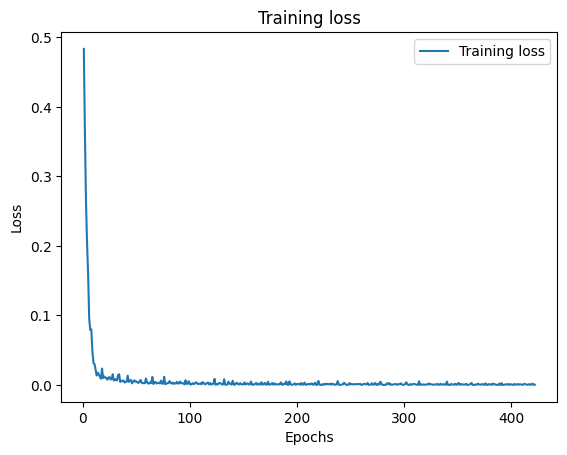

In [146]:
epochs = np.arange(1, len(loss_history) + 1)
plt.plot(epochs, np_loss_history, label='Training loss')
plt.title('Training loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.savefig('./img/loss_history.png')

In [155]:
model = torch.load(model_path + 'DeepOnet.pt').eval()
N = 200
lam = torch.arange(1, N+1).reshape(N, 1).float()
# 创建包含N个1的张量
y = torch.ones(N).reshape(N, 1)
predict = model(lam, y)

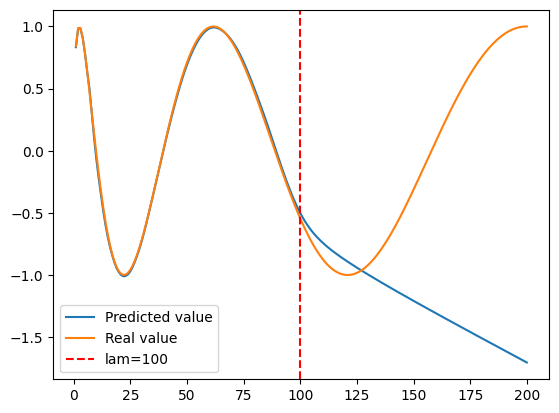

In [156]:
from matplotlib import pyplot as plt
lam = lam.detach().numpy()
predict = predict.detach().numpy()
real_value = np.sin(np.sqrt(lam))
plt.plot(lam, predict, label='Predicted value')
plt.plot(lam, real_value, label='Real value')
plt.axvline(x=100, color='red', linestyle='--', label='lam=100')
plt.legend()
plt.savefig('./img/lam_predictaty=1.png')

# 对于lambda梯度下降

In [112]:
from torch.autograd import Variable

# 假设 lam 是一个可训练参数
lam = Variable(torch.tensor([np.pi**2+1]), requires_grad=True).reshape(1, 1)
y = Variable(torch.tensor([1.0]), requires_grad=True).reshape(1, 1)

# 假设 model 是从文件中加载的模型
model_path = './models/'
model = torch.load(model_path + 'DeepONet.pt')

# 计算模型输出
output = model(lam, y)

# 定义 loss，即 |model(lam, 1)|^2
loss = torch.abs(output)**2

lam.retain_grad()

# 计算 loss 对 lam 和 y 的梯度
loss.backward()

# 打印结果
print("Original lam:", lam.data.numpy())
print("Model output:", output.data.numpy())
print("Gradient:", lam.grad.data.numpy())

# 梯度下降更新 lam
learning_rate = 0.01
lam.data.sub_(learning_rate * lam.grad)

# 打印更新后的 lam
print("Updated lam:", lam.data.numpy())

Original lam: [[10.869604]]
Model output: [[-0.19308583]]
Gradient: [[0.05437018]]
Updated lam: [[10.8690605]]


In [158]:
from torch.autograd import Variable
def eigen_optimizer(model,initial_value,bound_value,type,lr=0.01,max_iter=10000,epsilon=1e-4,print_loss=False):
    if type=='SGD':
        # 假设 lam 是一个可训练参数
        lam = Variable(torch.tensor([initial_value]), requires_grad=True).reshape(1, 1)
        y = Variable(torch.tensor([bound_value]), requires_grad=False).reshape(1, 1)
        # 定义学习率
        learning_rate = lr

        # 定义优化器的手动实现
        for epoch in range(max_iter):
            # 计算模型输出
            output = model(lam, y)
            
            # 定义 loss，即 |model(lam, 1)|^2
            loss = torch.abs(output)**2

            # 清零梯度
            lam.grad = None
            y.grad = None
            lam.retain_grad()
            # 计算 loss 对 lam 和 y 的梯度
            loss.backward()

            # 手动更新 lam 参数
            lam.data.sub_(learning_rate * lam.grad.data)

            # 打印更新后的 lam
            if epoch % 100 == 0:
                if print_loss:
                    print("Epoch {}: Updated lam: {} Loss: {}".format(epoch, lam.data.numpy(),loss.data.numpy()))
                if loss.data.numpy()<epsilon:
                    break
    elif type=='Adam':
        # 假设 lam 是一个可训练参数
        lam = Variable(torch.tensor([initial_value]), requires_grad=True).reshape(1, 1)
        y = Variable(torch.tensor([bound_value]), requires_grad=False).reshape(1, 1)

        # 初始化参数
        beta1 = 0.9
        beta2 = 0.999

        m = torch.zeros_like(lam)
        v = torch.zeros_like(lam)
        t = 0

        # 迭代更新参数
        for epoch in range(max_iter):
            # 计算模型输出
            output = model(lam, y)
            
            # 定义 loss，即 |model(lam, 1)|^2
            loss = torch.abs(output)**2

            # 清零梯度
            lam.grad = None
            y.grad = None
            lam.retain_grad()
            
            # 计算梯度
            loss.backward()

            # 更新一阶和二阶矩
            t += 1
            m = beta1 * m + (1 - beta1) * lam.grad.data
            v = beta2 * v + (1 - beta2) * lam.grad.data**2

            # 使用修正后的一阶和二阶矩计算参数更新
            m_hat = m / (1 - beta1**t)
            v_hat = v / (1 - beta2**t)

            # 手动更新参数
            lam.data.sub_(lr * m_hat / (torch.sqrt(v_hat) + epsilon))

            # 打印更新后的 lam
            if epoch % 100 == 0:
                if print_loss:
                    print("Epoch {}: Updated lam: {} Loss: {}".format(epoch, lam.data.numpy(),loss.data.numpy()))
                if loss.data.numpy()<epsilon:
                    break
    return lam.data.numpy()[0][0]

In [162]:
model = torch.load(model_path + 'DeepONet.pt').eval()
lam = eigen_optimizer(model,initial_value=4*np.pi**2+1,bound_value=1.0,type='Adam',lr=0.01,max_iter=10000,epsilon=1e-7,print_loss=True)

Epoch 0: Updated lam: [[40.46842]] Loss: [[0.00475456]]
Epoch 100: Updated lam: [[39.730743]] Loss: [[0.00013269]]
Epoch 200: Updated lam: [[39.590096]] Loss: [[9.622016e-08]]


In [163]:
lam,4*np.pi**2

(39.590096, 39.47841760435743)

In [164]:
P = 200
lam_arr = lam*torch.ones(P).reshape(P, 1)
y = torch.linspace(0, 1, P).reshape(P, 1)
model.eval()
predict = model(lam_arr, y)
predict = predict.detach().numpy()
real_value = np.sin(np.sqrt(4*np.pi**2)*y.detach().numpy())

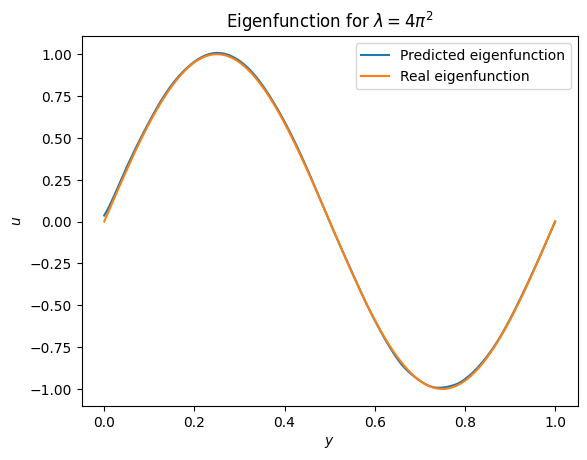

In [169]:
# 绘制预测特征值对应的特征函数
plt.plot(y.detach().numpy(), predict, label='Predicted eigenfunction')
plt.plot(y.detach().numpy(), real_value, label='Real eigenfunction')
plt.xlabel(r'$y$')
plt.ylabel(r'$u$')
plt.title(r'Eigenfunction for $\lambda = 4\pi^2$')
plt.legend()
plt.savefig('./img/eigenfunction_predict.png')

In [131]:
model = torch.load(model_path + 'DeepONet.pt').eval()
eigen_optimizer(model,initial_value=3.0,bound_value=1.0,type='Adam',lr=0.01,max_iter=10000,epsilon=1e-7)

9.61104

In [134]:
eig_set = []
for i in range(1,100):
    print(f'intial_value: {i}')
    lam = eigen_optimizer(model,initial_value=float(i),bound_value=1.0,type='Adam',lr=0.01,max_iter=10000,epsilon=1e-6)
    eig_set.append(lam)

intial_value: 1
intial_value: 2
intial_value: 3
intial_value: 4
intial_value: 5
intial_value: 6
intial_value: 7
intial_value: 8
intial_value: 9
intial_value: 10
intial_value: 11
intial_value: 12
intial_value: 13
intial_value: 14
intial_value: 15
intial_value: 16
intial_value: 17
intial_value: 18
intial_value: 19
intial_value: 20
intial_value: 21
intial_value: 22
intial_value: 23
intial_value: 24
intial_value: 25
intial_value: 26
intial_value: 27
intial_value: 28
intial_value: 29
intial_value: 30
intial_value: 31
intial_value: 32
intial_value: 33
intial_value: 34
intial_value: 35
intial_value: 36
intial_value: 37
intial_value: 38
intial_value: 39
intial_value: 40
intial_value: 41
intial_value: 42
intial_value: 43
intial_value: 44
intial_value: 45
intial_value: 46
intial_value: 47
intial_value: 48
intial_value: 49
intial_value: 50
intial_value: 51
intial_value: 52
intial_value: 53
intial_value: 54
intial_value: 55
intial_value: 56
intial_value: 57
intial_value: 58
intial_value: 59
intial

In [138]:
#np.save('./data/eig_set.npy',np.array(eig_set))

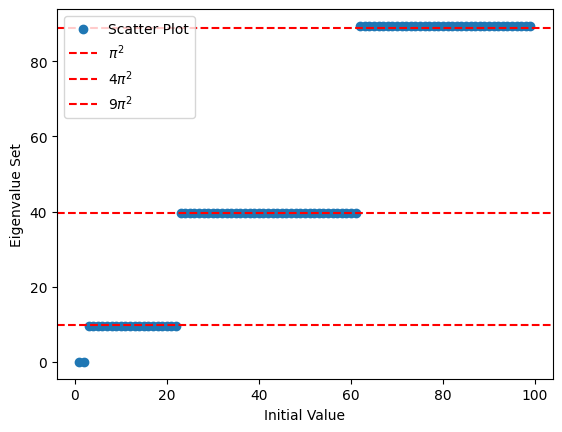

In [140]:
initial_value = np.arange(1,100)

# Scatter plot
plt.scatter(initial_value, eig_set, label='Scatter Plot')

# Draw dashed lines at y=pi**2, 4*pi**2, 9*pi**2
plt.axhline(y=np.pi**2, color='red', linestyle='--', label=r'$\pi^2$')
plt.axhline(y=4*np.pi**2, color='red', linestyle='--', label=r'$4\pi^2$')
plt.axhline(y=9*np.pi**2, color='red', linestyle='--', label=r'$9\pi^2$')

plt.xlabel('Initial Value')
plt.ylabel('Eigenvalue Set')
plt.legend()
plt.show()

In [ ]:
'''
# 使用模型进行预测
model.eval()
with torch.no_grad():
    lambda_test = torch.tensor([1.5])
    y_test = torch.tensor([0.8])
    input_test = torch.stack((lambda_test, y_test), dim=1)
    prediction = model(input_test)
    print(f'Predicted value: {prediction.item()}')
    print(f'True value: {target_operator(lambda_test, y_test).item()}')
'''